In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Dataset imports:
from data.dataset_alt import *

# Data augmenter imports:
from data.data_augmentation import *

# Torch imports:
import torch
import torch.nn as nn
from torch import optim
from torchvision import transforms
from torch.utils.data import Subset, DataLoader, random_split

# Model imports:
from model_alt import *

# Train and evaluation imports:
from train import train
from evaluate import evaluate

# Custom Transforms imports:
from custom_transforms import *

# Plotting imports:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# General imports:
import os
import json
import math
import random

# SKLearn imports:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

# Other imports:
from tqdm import tqdm

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

### Defining the device

In [4]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print(f'Current device: {device}')

Current device: cuda


In [5]:
torch.backends.cudnn.benchmark = True

# Data preprocessing:

### Getting the mean and standard deviation of the dataset in order to apply normalization on the data:

In [6]:
# Getting the path to the .txt file that contains the mean and std:
DATA_STATS_FILE_NAME = "dataset_stats.txt"
STATS_FILE_PATH = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data', DATA_STATS_FILE_NAME)

# Reading the statistics file:
stats_dict = None
with open(STATS_FILE_PATH, 'r') as stats_file:
    stats_dict = json.loads(stats_file.read())
    
mean, std = stats_dict['mean'], stats_dict['std']

print(f'Dataset mean: \t\t\t{mean}\nDataset standard deviation: \t{std}')

Dataset mean: 			[0.4944856143767711, 0.4950292797617727, 0.4954058302766022]
Dataset standard deviation: 	[0.28984177278042145, 0.28989603043370027, 0.28941759149050483]


### Creating the preprocessing operations that the images will undergo:

In [7]:
# This Compose includes the following:
#     1) Transforms the images to tensors.
#     2) Normalized the dataset.
#     3) Sharpens the images.

# Creating the sharpness transform:
sharpen = Sharpen(sharpness_factor=2)

image_dim = (270, 360)

image_preprocessing = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.transforms.Normalize(mean, std),
                            T.Resize(image_dim),
                            sharpen])

# Defining the dataset:

In [8]:
# Creating the dataset instance:
dataset = SkinDataset(transforms=image_preprocessing)

### The dataset class distribution:

In [9]:
data_dist = dataset.get_data_distribution()
data_dist

{'akiec': 327,
 'bcc': 514,
 'bkl': 1099,
 'df': 115,
 'mel': 1113,
 'nv': 6705,
 'vasc': 142}

### Plotting the data distribution:

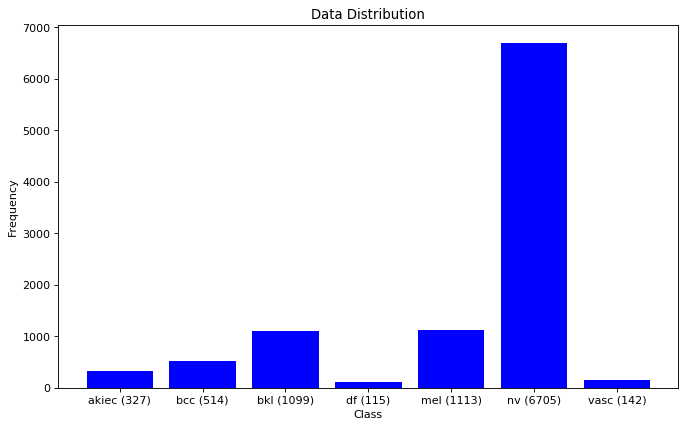

In [10]:
figure(figsize=(10, 6), dpi=80)
plt.title('Data Distribution')

y = list(data_dist.values())
x = [f'{label} ({count})' for label, count in zip(data_dist.keys(), data_dist.values())]

plt.xlabel("Class")
plt.ylabel("Frequency")
plt.bar(x, y, color='b')

plt.show()

### Defining the Dataset object:

In [11]:
dataset = SkinDataset()

### Splitting the dataset into train, validation, and test sets:

In [57]:
# Defining the path where the test indecies will be saved:
save_path = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'data', 'test_split_indecies.txt')

with open(save_path, 'r') as file:
    ind_dict = json.loads(file.read())
    test_set_idx = np.array(json.loads(ind_dict['test_indecies']))

array([7459, 9566, 4149, ..., 7350, 2818, 1145])

In [58]:
# Defining the proportions of how the dataset will be split:
train_proportion = 0.8
validation_proportion = 0.2
test_proportion = 0.2

# Defining the sizes of the splits:

# 1) The train set size:
train_size = math.ceil(train_proportion * len(dataset))

# 2) The validation set size:
validation_size = math.ceil(validation_proportion * len(dataset))

# 3) The test set size:
test_size = math.floor(test_proportion * len(dataset))

# Defining the indecies of the train, validation and test sets:
all_indecies = np.random.choice(list(range(len(dataset))), (10, len(dataset) // 10), replace=False)

train_set_ind = np.random.choice(list(range(all_indecies.shape[0])), int(train_proportion * 10), replace=False)
val_set_ind = np.random.choice(list(range(all_indecies.shape[0])), int(validation_proportion * 10), replace=False)
test_set_ind = np.random.choice(list(range(all_indecies.shape[0])), int(test_proportion * 10), replace=False)

train_set_ind = np.append([], all_indecies[train_set_ind]).astype(np.int)
val_set_ind = np.append([], all_indecies[val_set_ind]).astype(np.int)
test_set_ind = np.append([], all_indecies[test_set_ind]).astype(np.int)

# # Defining the train, validation, and test sets:
train_set = SkinDataset(indecies=train_set_ind)
validation_set = SkinDataset(transforms=image_preprocessing, indecies=val_set_ind)
test_set = SkinDataset(transforms=image_preprocessing, indecies=test_set_idx)

### Creating the DataLoader objects:

In [59]:
train_batch_size, validation_batch_size, test_batch_size = 8, 8, 8

# Setting the num_workers to the number of cores on this machine.
num_workers = 8

train_loader = DataLoader(train_set, shuffle=True, batch_size=train_batch_size, num_workers=num_workers, pin_memory=True)
validation_loader = DataLoader(validation_set, shuffle=True, batch_size=validation_batch_size, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_set, shuffle=False, batch_size=test_batch_size, num_workers=num_workers, pin_memory=True)

# Loading the model:

In [60]:
MODEL_NAME = f'skin_cancer_model'
MODEL_PATH = os.path.join(os.path.abspath(os.path.dirname("__file__")), MODEL_NAME)

In [61]:
image_dim = (270, 360)
model = Model(image_dim=image_dim, num_classes=dataset.num_classes)
model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [62]:
test_accuracy = evaluate(model=model, data_loader=test_loader, device=device)

In [63]:
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 95.70%


# Class Accuracies

In [64]:
nb_classes = 7
preds_list = []
confusion_mat = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes, _, _) in tqdm(enumerate(test_loader)):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs.float())
        _, preds = torch.max(outputs, 1)
        for item in preds:
            preds_list.append(item.item())
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_mat[t.long(), p.long()] += 1

126it [00:02, 44.03it/s]


In [65]:
classes = np.unique(test_set.labels)

class_accuracies = confusion_mat.diag()/confusion_mat.sum(1)
class_acc_dict = dict(zip(classes, class_accuracies.tolist()))

for cls, cls_acc in zip(classes, class_accuracies):
    print(f'{cls}: {cls_acc * 100:.2f}%')

akiec: 100.00%
bcc: 98.04%
bkl: 97.96%
df: 100.00%
mel: 87.13%
nv: 96.04%
vasc: 100.00%


In [66]:
ground_truth = test_set.mapped_labels

In [67]:
preds_list = np.array(preds_list)

### Printing the confusion matrix:

In [68]:
conf_mat = confusion_matrix(ground_truth, preds_list)

In [69]:
print(conf_mat)

[[ 36   0   0   0   0   0   0]
 [  0  50   0   0   0   1   0]
 [  0   0  96   0   0   2   0]
 [  0   0   0  13   0   0   0]
 [  0   0   2   1  88  10   0]
 [  1   7   6   1  11 655   1]
 [  0   0   0   0   0   0  20]]


### Testing the model with precision, recall, and f1-score:

In [70]:
print(classification_report(ground_truth, preds_list))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        36
           1       0.88      0.98      0.93        51
           2       0.92      0.98      0.95        98
           3       0.87      1.00      0.93        13
           4       0.89      0.87      0.88       101
           5       0.98      0.96      0.97       682
           6       0.95      1.00      0.98        20

    accuracy                           0.96      1001
   macro avg       0.92      0.97      0.95      1001
weighted avg       0.96      0.96      0.96      1001

